# CPO for QAR

L'obiettivo generale dell'esercizio è di analizzare quali attributi contribuiscono maggiormente ad una regola di associazione quantitativa del tipo: AI -> Aj[b, e], dove: AI = insieme di intervalli etichettati su attibuti diversi da Aj; Aj[b, e] = intervallo su un attributo target. Vogliamo, quindi, valutare quanto ogni test contribuisce a far valere la regola. Per riuscire a fare ciò, utilizziamo il concetto Shapley value. In altri termini, noi abbiamo:
1. un dataset quantitativo;
2. un intervallo target Aj (che rappresenta il conseguente della regola (ovvero è il nostro Y) );
3. un insieme di test (che rappresenta la nostra X).
L'obiettivo dell'esercizio è di stimare quanto ciascun test contribuisca alla qualità della regola X -> Y usando la metrica del Shapley value, la quale viene calcolata su una funzione di payoff basata sulla J-measure.
Prima di tutto capiamo 3 concetti fondamentali:
4. shapley value -> serve per rispondere alla domanda: "Quanto contribuisce un singolo partecipante (nel nostro caso, un test) al risultato globale di una coalizione?" Nel nostro esercizio, ogni test è un "giocatore"; la coalizione è un sottoinsieme di test e il risultato della coalizione è la qualità della regola generata da questi test;
5. funzione di payoff -> assegna un valore numerico a ogni coalizione (cioè sottoinsieme di test), rappresentando quanto è buona la regola che quei test generano;
6. j-measure -> metrica informativa che serve a valutare quanto è interessante una regola del tipo: Ai -> Aj[b, e].

In [5]:
from dataclasses import dataclass   # per rappresentare gli intervalli
import dataset
import polars as pl

# Classe che rappresenta un intervallo su un attributo quantitativo, ovverosia un elemento è del tipo: CO[0, 1] --> significa che l'attributo CO assume valori da 0 a 1 (inclusi).
@dataclass(frozen=True) # Rende l'oggetto immutabile
class Interval:
    label: str   # Nome dell'attributo (es. "CO", "NOX")
    begin: int   # Estremo inferiore dell'intervallo
    end: int     # Estremo superiore dell'intervallo (inclusivo)

# Definizione di un intervallo target -> sarebbe il conseguente (Y) della regola
target_interval = Interval("CO", 0, 1)  # Questo intervallo lo utilizzeremo per calcolare la J-measure della regola

# Creo il dataset di esempio per riuscire a fare dei test
df = pl.DataFrame({
    "CO":   [0, 1, 1, 2, 3, 3],
    "OO":   [5, 4, 3, 2, 1, 0],
    "NOX":  [1, 1, 1, 2, 3, 0],
})

df

CO,OO,NOX
i64,i64,i64
0,5,1
1,4,1
1,3,1
2,2,2
3,1,3
3,0,0


Adesso dobbiamo creare gli intervalli etichettati Ai, andando a trasformare i test logici (come ad esempio: CO >= 1; CO <= 3) in intervalli veri e propri, in modo tale da:
1. calcolare quante righe del dataset soddisfano l'intervallo;
2. stimare la qualità di una regola;
3. fare il calcolo della Shapley value.


In [6]:
from typing import Set
from dataclasses import dataclass

# Definisco la classe 'Test', che mi permette di rappresentare un test logico (esempio: "CO ≤ 2"; "NOX ≥ 1") che dopo mi serviranno per creare gli intervalli
@dataclass(frozen=True)
class Test:
    label: str   # Nome attributo
    op: str      # Operatore
    value: int   # Soglia numerica

# Funzione che, dati i test, costruisce i corrispondenti intervalli chiusi [b, e] etichettati --> quindi la funzione 'get_labelled_intervals' prende i test logici e li trasforma in intervalli del tipo [b, e].
def get_labelled_intervals(tests: Set[Test]) -> Set[Interval]:
    AI = []
    for test in tests:  # Per ogni test controllo se esso è del tipo Aj <= e oppure Aj >= b
        if test.op == '<=': # Scorro tutti i test ricevuti e se il test è del tipo Aj <= e, allora capiamo qual è l'intervallo che
                            # finisce in 'e' e da dove deve partire 'b' -> quindi se il test è Aj <= e cerco un test del tipo Aj >= b

            lower_bounds = [    # questi sono i candidati per essere l'estremo inferiore (ovvero 'b') dell'intervallo
                t for t in tests
                if t.op == '>=' and t.label == test.label and t.value <= test.value
            ]

            # Se esistono candidati, allora prendiamo il valore più grande, in modo tale da costruire l'intervallo più stretto possibile
            if lower_bounds:
                b = max(lower_bounds, key=lambda t: t.value).value

            # Se invece non esistono, allora prendiamo il valore minimo presente nel dataset
            else:
                b = min(df[test.label])  # Estremo inferiore naturale
            e = test.value
            AI.append(Interval(test.label, b, e))   # Creiamo l'intervallo finale e lo aggiungiamo alla lista

        # Se invece il test è del tipo Aj >= b, allora cerchiamo un test del tipo Aj <= e
        elif test.op == '>=':
            upper_bounds = [    # candidati per l'estremo superiore dell'intervallo
                t for t in tests
                if t.op == '<=' and t.label == test.label and t.value >= test.value
            ]
            if upper_bounds:    # se ci sono candidati, allora prendo il minimo, altrimenti prendo il massimo
                e = min(upper_bounds, key=lambda t: t.value).value
            else:
                e = max(df[test.label])

            b = test.value
            AI.append(Interval(test.label, b, e))   # costruisco l'intervallo

    return set(AI)  # Ritorna quindi l'insieme degli intervalli

A questo punto, dobbiamo calcolare il supporto di un insieme di intervalli AI, ovvero essenzialmente dobbiamo capire quante righe del dataset rispettano tutti gli intervalli.

In [7]:
from collections import defaultdict
import polars as pl

def make_AI_expr(AI: set[Interval]) -> pl.Expr: # crea un'espressione per filtrare il dataframe, andando a selezionare le righe che soddisfano tutti gli intervalli in Ai
    intervals_by_attr = defaultdict(list)   # Raggruppa gli intervalli per attributo -> Se si ha: AI = {Interval(CO, 1, 2), Interval(CO, 3, 4), Interval(NOX, 1, 3)} allora si  ottiene: {CO: [Interval(1,2), Interval(3,4)], NOX: [Interval(1,3)]}
    for interval in AI:
        intervals_by_attr[interval.label].append(interval)

    overall_expr = pl.lit(True) # Inizializza l'espressione booleana globale

    # Per ogni attributo, crea l'espressione combinata con l'OR dei suoi intervalli
    for label, intervals in intervals_by_attr.items():
        attr_expr = pl.lit(False)
        for interval in intervals:
            attr_expr |= pl.col(label).is_between(interval.begin, interval.end)

        overall_expr &= attr_expr   # Combina con AND su tutti gli attributi

    return overall_expr

# Calcola il supporto relativo dell'insieme di intervalli sul dataset globale
def get_support(AI: set[Interval]) -> float:
    filtered_df = df.filter(make_AI_expr(AI))  # Seleziona le righe che soddisfano tutti gli intervalli
    return len(filtered_df) / len(df)          # Calcola il supporto come: righe soddisfatte / totale

# Verifica che la funzione 'get_support' funzioni effettivamente correttamente (e lo fa su un caso noto)
def test_get_support():
    AI_test = {Interval("CO", 0, 1)}
    support = get_support(AI_test)
    assert support == 0.5, f"Errore nel calcolo del supporto: ottenuto {support}"

# Eseguo il test
test_get_support()

Adesso calcoliamo la j-measure e costruiamo la funzione di payoff.

In [8]:
import numpy as np

def j_measure(X: set[Interval], Y: set[Interval]) -> float: # Calcola la J-measure per una regola X -> Y
    p_X = get_support(X)  # calcolo il supporto dell'antecedente
    if p_X == 0:    # se la regola non si verifica mai, allora non dà alcun contributo informativo
        return 0

    p_Y = get_support(Y)  # calcolo il supporto del conseguente
    p_Y_given_X = get_support(X | Y) / p_X  # calcolo la probabilità condizionata: P(Y | X)

    # Calcolo la j-measure (la formula è scritta sulle slide)
    result = 0.0
    # Primo termine (caso Y vero)
    if p_Y_given_X != 0:
        result += p_Y_given_X * np.log2(p_Y_given_X / p_Y)
    # Secondo termine (caso Y falso)
    if p_Y_given_X != 1:
        result += (1 - p_Y_given_X) * np.log2((1 - p_Y_given_X) / (1 - p_Y))

    return result * p_X

# Creo una funzione di payoff (CPO) per un intervallo target Ai
def make_cpo(A_i: Interval):
    def cpo(T_minus_i: set[Test]) -> float:
        X = get_labelled_intervals(T_minus_i)
        return j_measure(X, {A_i})

    return cpo

A questo punto, dobbiamo fare il calcolo approssimato del valore di Shapley per un singolo test logico, rispetto ad una funzione di payoff cpo.

In [9]:
import random
from math import factorial

# Stima del valore di Shapley per un test, usando n_samples campioni
def estimate_shapley(T: set[Test], test: Test, n_samples: int, cpo: callable) -> float: #T: insieme di tutti i test Ti (tranne quelli sul target); test: il test per cui stimare lo Shapley value; n_samples: numero di coalizioni casuali da generare; cpo: funzione di payoff.

    T_without_test = T - {test}  # Rimuovo il test che stai valutando, perchè vogliamo calcolare quanto 'test' contribuisce alle coalizzioni in cui non è presente
    sampled_subsets = set()
    while len(sampled_subsets) < n_samples: # Genero n_samples sotto-insiemi casuali di T senza 'test' e ogni sotto-insieme Xi rappresenta una possibile coalizione
        sampled_subsets.update({
            frozenset(random.sample(list(T_without_test), random.randint(1, len(T_without_test) - 1)))
            for _ in range(n_samples - len(sampled_subsets))
        })

    print("Estimating with", len(sampled_subsets), "samples")
    numerator = 0
    denominator = 0
    for Xi in sampled_subsets:
        size = len(Xi)
        weight = factorial(size) * factorial(len(T) - size - 1)  # Peso combinatorio della coalizione

        delta_forward = cpo(Xi | {test}) - cpo(Xi)  # Calcolo il marginal gain -> quanto contribuisce il test se lo si aggiunge alla coalizione Xi
        Xi_dual = T - Xi
        delta_dual = cpo(Xi_dual) - cpo(Xi_dual | {test})   # Calcolo l'opposto del marginal gain, ovvero quanto peggiore diventa la coalizione se si toglie Xi

        numerator += weight * (delta_forward + delta_dual)
        denominator += 2 * weight  # Ogni contributo ha due componenti

    return numerator / denominator  # ritorno lo shapley value stimato

# Applicazione sul dataset della qualità dell'aria

In [10]:
# Controllo se il dataset è già stato caricato
try:
    dataset
    print(" Dataset già caricato")
except NameError:
    print(" Dataset non presente: lo scarico...")

    # Installo i pacchetti necessari (solo se non già installati)
    try:
        import ucimlrepo
        import polars as pl
    except ImportError:
        import sys
        !{sys.executable} -m pip install ucimlrepo polars

    # Scarico il dataset Air Quality
    from ucimlrepo import fetch_ucirepo
    dataset = fetch_ucirepo(id=360)
    print("Dataset scaricato con successo!")

dataset.data.features

 Dataset non presente: lo scarico...
Dataset scaricato con successo!


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


In [11]:
# Come nel primo eserczio, una volta che abbiamo caricato il dataset, dobbiamo ripulirlo e prepararlo
import polars as pl

aq = pl.from_pandas(dataset.data.features)
aq = (
    aq
    # Rimuovo le colonne inutili
    .drop(["Date", "Time", "RH", "AH"])

    # Rimuovo tutte le colonne che terminano con "(GT)" (valori target originali)
    .drop(filter(lambda col: col.endswith("(GT)"), aq.columns))

    # Rinomino le colonne
    .rename({
        'PT08.S1(CO)': 'CO',    # sensore CO
        'PT08.S2(NMHC)': 'NMHC',
        'PT08.S3(NOx)': 'NOX',
        'PT08.S4(NO2)': 'NOO',
        'PT08.S5(O3)': 'OOO'
    })

    .filter(pl.any_horizontal(pl.all().ne(-200)))   # Elimino le righe con i valori non validi
)

aq  # Dataset sistemato

CO,NMHC,NOX,NOO,OOO,T
i64,i64,i64,i64,i64,f64
1360,1046,1056,1692,1268,13.6
1292,955,1174,1559,972,13.3
1402,939,1140,1555,1074,11.9
1376,948,1092,1584,1203,11.0
1272,836,1205,1490,1110,11.2
…,…,…,…,…,…
1314,1101,539,1374,1729,21.9
1163,1027,604,1264,1269,24.3
1142,1063,603,1241,1092,26.9


Adesso codifichiamo tutte le colonne del dataset in valori interi, in modo tale che sia possibile creare i test.

In [14]:
encoder = {
    col: sorted(aq.get_column(col).unique().to_list())  # Prende i valori unici presenti nella colonna e li ordino in una lista
    for col in aq.columns
}

# Codifico ogni colonna usando la mappatura appena creata
df = aq.select([
    pl.col(column).replace_strict(
        dict(zip(values, range(len(values))))  # {valore originale: indice intero}
    ).alias(column)
    for column, values in encoder.items()
])

# Per ogni colonna, mapperemo i suoi valori reali a interi 0...n
# Esempio: se "CO" ha valori [1.2, 3.5, 5.0] -> encoder["CO"] = [1.2, 3.5, 5.0]
#         e mappatura = {1.2: 0, 3.5: 1, 5.0: 2}

df.sort("CO")   # Visualizzo il dataframe codificato, ordinato per la colonna "CO"

CO,NMHC,NOX,NOO,OOO,T
i64,i64,i64,i64,i64,i64
0,11,1202,85,12,115
1,4,1209,102,7,111
2,6,1210,118,11,109
3,19,1177,95,19,116
3,37,1154,91,25,123
…,…,…,…,…,…
1036,1209,260,1543,1716,240
1037,1171,240,1544,1726,214
1038,1239,0,1574,1729,141


Arrivati a questo punto, abbiamo il dataset codificato; il target della regola (Y); generato i test e implementato la funzione di payoff. Calcoliamo, allora, la shapley value per un test.

In [15]:
from random import sample
from tqdm import tqdm

target_interval = Interval("NMHC", 1046, 2214)  # Definisco l'intervallo target della regola (il consequente Y)

# Escludo la colonna target dalla generazione dei test
testable_attributes = set(df.columns) - {target_interval.label}

# Genera tutti i test possibili su ogni colonna diversa da NMHC. Per ogni valore codificato dell’attributo, crea un test ≤ o ≥
T_all = [
    Test(attr, op, val)
    for attr in testable_attributes
    for val in encoder[attr]
    for op in ["<=", ">="]
]

T = set(sample(T_all, k=170))   # Estrai un sottoinsieme casuale di 170 test da T_all
test = T.pop()  # Estraggo un test da T per calcolarne lo Shapley value
cpo_func = make_cpo(target_interval)    # Crea la funzione di payoff cpo

test

output = []  # Lista per memorizzare i risultati di Shapley stimati
# Per ogni valore di n_samples da 1 a 170, con passo 5
for n_samples in tqdm(range(1, 170, 5), desc="Global progress"):
    # Calcola lo Shapley value approssimato del test selezionato
    shapley_val = estimate_shapley(T, test, n_samples, cpo_func)

    output.append(shapley_val)  # salvo il risultato -> NB!! dal grafico vedo che la distribuzione dello shapley value è attorno allo 0

Global progress:   0%|          | 0/34 [00:00<?, ?it/s]

Estimating with 1 samples
Estimating with 6 samples


Global progress:   6%|▌         | 2/34 [00:00<00:06,  4.92it/s]

Estimating with 11 samples


Global progress:   9%|▉         | 3/34 [00:01<00:11,  2.66it/s]

Estimating with 16 samples


Global progress:  12%|█▏        | 4/34 [00:01<00:16,  1.79it/s]

Estimating with 21 samples


Global progress:  15%|█▍        | 5/34 [00:03<00:22,  1.29it/s]

Estimating with 26 samples


Global progress:  18%|█▊        | 6/34 [00:04<00:27,  1.00it/s]

Estimating with 31 samples


Global progress:  21%|██        | 7/34 [00:06<00:33,  1.24s/it]

Estimating with 36 samples


Global progress:  24%|██▎       | 8/34 [00:08<00:38,  1.48s/it]

Estimating with 41 samples


Global progress:  26%|██▋       | 9/34 [00:10<00:43,  1.73s/it]

Estimating with 46 samples


Global progress:  29%|██▉       | 10/34 [00:13<00:47,  2.00s/it]

Estimating with 51 samples


Global progress:  32%|███▏      | 11/34 [00:16<00:51,  2.26s/it]

Estimating with 56 samples


Global progress:  35%|███▌      | 12/34 [00:19<00:55,  2.52s/it]

Estimating with 61 samples


Global progress:  38%|███▊      | 13/34 [00:22<00:58,  2.78s/it]

Estimating with 66 samples


Global progress:  41%|████      | 14/34 [00:26<01:00,  3.04s/it]

Estimating with 71 samples


Global progress:  44%|████▍     | 15/34 [00:30<01:02,  3.28s/it]

Estimating with 76 samples


Global progress:  47%|████▋     | 16/34 [00:34<01:04,  3.58s/it]

Estimating with 81 samples


Global progress:  50%|█████     | 17/34 [00:39<01:08,  4.02s/it]

Estimating with 86 samples


Global progress:  53%|█████▎    | 18/34 [00:44<01:10,  4.39s/it]

Estimating with 91 samples


Global progress:  56%|█████▌    | 19/34 [00:50<01:11,  4.77s/it]

Estimating with 96 samples


Global progress:  59%|█████▉    | 20/34 [00:55<01:10,  5.02s/it]

Estimating with 101 samples


Global progress:  62%|██████▏   | 21/34 [01:01<01:07,  5.21s/it]

Estimating with 106 samples


Global progress:  65%|██████▍   | 22/34 [01:07<01:05,  5.46s/it]

Estimating with 111 samples


Global progress:  68%|██████▊   | 23/34 [01:13<01:02,  5.64s/it]

Estimating with 116 samples


Global progress:  71%|███████   | 24/34 [01:20<00:59,  5.90s/it]

Estimating with 121 samples


Global progress:  74%|███████▎  | 25/34 [01:26<00:54,  6.09s/it]

Estimating with 126 samples


Global progress:  76%|███████▋  | 26/34 [01:33<00:50,  6.32s/it]

Estimating with 131 samples


Global progress:  79%|███████▉  | 27/34 [01:40<00:45,  6.54s/it]

Estimating with 136 samples


Global progress:  82%|████████▏ | 28/34 [01:48<00:41,  6.97s/it]

Estimating with 141 samples


Global progress:  85%|████████▌ | 29/34 [01:57<00:37,  7.47s/it]

Estimating with 146 samples


Global progress:  88%|████████▊ | 30/34 [02:05<00:30,  7.74s/it]

Estimating with 151 samples


Global progress:  91%|█████████ | 31/34 [02:14<00:24,  8.11s/it]

Estimating with 156 samples


Global progress:  94%|█████████▍| 32/34 [02:23<00:16,  8.36s/it]

Estimating with 161 samples


Global progress:  97%|█████████▋| 33/34 [02:32<00:08,  8.66s/it]

Estimating with 166 samples


Global progress: 100%|██████████| 34/34 [02:43<00:00,  4.79s/it]


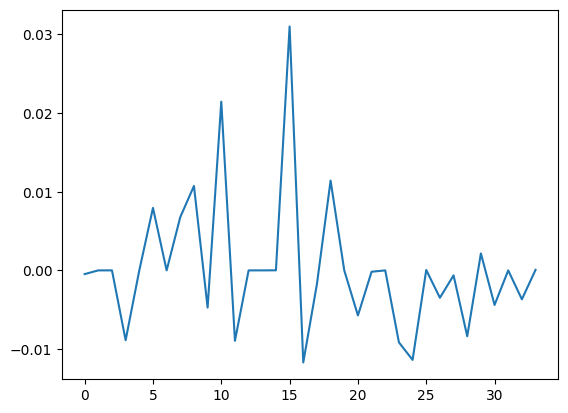

In [20]:
import matplotlib.pyplot as plt
plt.plot(output)